In [ ]:
import cv2
import numpy as np

def scan_document(image_path):
    """Scans a document image and returns the scanned image.

    Args:
        image_path: The path to the document image.

    Returns:
        The scanned image.
    """

    # 1. Load the image
    img = cv2.imread(image_path)
    orig = img.copy()

    # 2. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Blur the image
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Detect edges using Canny
    edges = cv2.Canny(blur, 50, 150)

    # 5. Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 6. Find the largest contour (assumed to be the document)
    largest_contour = max(contours, key=cv2.contourArea)

    # 7. Approximate the contour to a polygon
    peri = cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)

    # 8. If the polygon has 4 sides, it's likely a document
    if len(approx) == 4:
        # 9. Warp the image to a rectangle
        warped = four_point_transform(orig, approx.reshape(4, 2))

        # 10. Convert to grayscale and threshold to get a clean scan
        warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
        scanned = cv2.threshold(warped, 127, 255, cv2.THRESH_BINARY)[1]

        return scanned

    return None

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sort_points(pts):
    """
    Ordena un arreglo de 4 puntos (x, y) en el orden:
    [top-left, top-right, bottom-right, bottom-left]
    """
    # pts: numpy array de shape (4, 2)
    # 1) Ordenar por Y (fila), de menor a mayor
    pts = pts[np.argsort(pts[:,1]), :]  # ordena por la componente y
    # 2) Los dos primeros son el top, los dos últimos el bottom
    top = pts[:2, :]
    bottom = pts[2:, :]

    # Ordenar left-right en top
    top = top[np.argsort(top[:,0]), :]
    # Ordenar left-right en bottom
    bottom = bottom[np.argsort(bottom[:,0]), :]

    # Reconstruir en orden
    return np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")


def four_point_transform(image, pts):
    """
    Hace el warp (corrección de perspectiva) dada una imagen y 4 puntos.
    La salida es la imagen "enderezada".
    """

    rect = sort_points(pts)
    (tl, tr, br, bl) = rect

    # Calcular los anchos y altos de la imagen transformada
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Coordenadas destino
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Calcular la matriz de transformación y hacer el warp
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped


def scan_document(image, debug=False):
    """
    Recibe una ruta de imagen o un np.array BGR (OpenCV).
    1) Convierte a gris y desenfoca
    2) Aplica Canny (bordes)
    3) Encuentra contornos
    4) Elige el de 4 vértices más grande
    5) Warp (perspectiva)
    6) Equalize + AdaptiveThreshold
    Retorna la imagen procesada en escala de grises (BN).

    Si debug=True, muestra las etapas intermedias con matplotlib.
    """

    # Si image es ruta (str), cargarla en BGR
    if isinstance(image, str):
        image = cv2.imread(image)

    orig = image.copy()

    # Convertir a gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Desenfocar (para reducir ruido). Ajusta el kernel a tu gusto (5, 5), (3,3), etc.
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detectar bordes con Canny. Ajusta 50,200 según tu necesidad.
    edges = cv2.Canny(blurred, 50, 200)

    # Buscar contornos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_approx = None
    max_area = 0

    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Ignorar contornos muy pequeños
        if area < 1000:
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        # Verificar si es un polígono de 4 vértices
        if len(approx) == 4 and area > max_area:
            best_approx = approx
            max_area = area

    # Si se encontró contorno de 4 vértices, warp
    if best_approx is not None:
        # Extraer los puntos y enderezar
        pts = best_approx.reshape(4, 2).astype("float32")
        warped = four_point_transform(orig, pts)
    else:
        # Fallback: no se encontró un documento con 4 vértices
        # Podrías usar boundingRect o simplemente quedarte con la imagen original
        warped = orig.copy()

    # Convertir a gris y realzar
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warped_gray = cv2.equalizeHist(warped_gray)

    # Aplicar binarizado adaptativo
    final = cv2.adaptiveThreshold(warped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 15, 15)

    # Debug: mostrar pasos
    if debug:
        fig, axs = plt.subplots(2, 3, figsize=(16, 8))
        axs = axs.ravel()

        axs[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(gray, cmap='gray')
        axs[1].set_title("Grayscale")
        axs[1].axis('off')

        axs[2].imshow(blurred, cmap='gray')
        axs[2].set_title("Blurred")
        axs[2].axis('off')

        axs[3].imshow(edges, cmap='gray')
        axs[3].set_title("Canny Edges")
        axs[3].axis('off')

        axs[4].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        axs[4].set_title("Warped (Perspective)")
        axs[4].axis('off')

        axs[5].imshow(final, cmap='gray')
        axs[5].set_title("Final (Binarized)")
        axs[5].axis('off')

        plt.tight_layout()
        plt.show()

    return final

In [ ]:
def scan_document(image, debug=False):
    if isinstance(image, str):
        image = cv2.imread(image)

    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 200)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_approx = None
    max_area = 0
    image_area = image.shape[0] * image.shape[1]

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 1000:
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        # Comprobar si tiene 4 vértices y es suficientemente grande
        if len(approx) == 4 and area > max_area and area > 0.25 * image_area:
            best_approx = approx
            max_area = area

    if best_approx is not None:
        pts = best_approx.reshape(4, 2).astype("float32")
        warped = four_point_transform(orig, pts)
    else:
        # Si no hay documento detectado, usar la imagen completa
        h, w = orig.shape[:2]
        pts = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype="float32")
        warped = four_point_transform(orig, pts)

    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warped_gray = cv2.equalizeHist(warped_gray)
    final = cv2.adaptiveThreshold(warped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 15, 15)

    if debug:
        fig, axs = plt.subplots(2, 3, figsize=(16, 8))
        axs = axs.ravel()

        axs[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(gray, cmap='gray')
        axs[1].set_title("Grayscale")
        axs[1].axis('off')

        axs[2].imshow(edges, cmap='gray')
        axs[2].set_title("Canny Edges")
        axs[2].axis('off')

        axs[3].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        axs[3].set_title("Warped (Perspective)")
        axs[3].axis('off')

        axs[4].imshow(final, cmap='gray')
        axs[4].set_title("Final (Binarized)")
        axs[4].axis('off')

        plt.tight_layout()
        plt.show()

    return final


# Version 3

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sort_points(pts):
    pts = pts[np.argsort(pts[:, 1])]
    top = pts[:2][np.argsort(pts[:2, 0])]
    bottom = pts[2:][np.argsort(pts[2:, 0])]
    return np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

def four_point_transform(image, pts):
    rect = sort_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def validate_contour(cnt, img_area, min_area_ratio=0.25, max_angle_range=50):
    if len(cnt) != 4:
        return False

    area = cv2.contourArea(cnt)
    if area < img_area * min_area_ratio:
        return False

    rect = sort_points(cnt.reshape(4, 2))
    tl, tr, br, bl = rect

    def angle(p1, p2, p3):
        v1 = np.array(p1) - np.array(p2)
        v2 = np.array(p3) - np.array(p2)
        return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)))

    angles = [
        angle(tl, tr, br),
        angle(tr, br, bl),
        angle(br, bl, tl),
        angle(bl, tl, tr)
    ]

    return np.ptp(angles) <= max_angle_range

def scan_document(image_path, debug=False):
    image = cv2.imread(image_path)
    orig = image.copy()

    RESCALED_HEIGHT = 500.0
    ratio = image.shape[0] / RESCALED_HEIGHT
    image = cv2.resize(image, (int(image.shape[1] / ratio), int(RESCALED_HEIGHT)))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    edged = cv2.Canny(dilated, 0, 84)

    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    best_approx = None
    img_area = image.shape[0] * image.shape[1]

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if validate_contour(approx, img_area):
            best_approx = approx
            break

    if best_approx is not None:
        warped = four_point_transform(orig, best_approx.reshape(4, 2) * ratio)
    else:
        h, w = orig.shape[:2]
        pts = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype="float32")
        warped = four_point_transform(orig, pts)

    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    sharpen = cv2.GaussianBlur(gray, (0, 0), 3)
    sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)
    final = cv2.adaptiveThreshold(sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 21, 15)

    if debug:
        plt.figure(figsize=(10, 6))
        plt.subplot(121), plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(122), plt.imshow(final, cmap='gray'), plt.title('Processed')
        plt.show()

    return final


# V3 with Logs

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger(__name__)

def sort_points(pts):
    logger.warning("Sorting points: %s", pts)

    pts = pts[np.argsort(pts[:, 1])]
    top = pts[:2][np.argsort(pts[:2, 0])]
    bottom = pts[2:][np.argsort(pts[2:, 0])]
    sorted_pts = np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

    logger.warning("Sorted points: %s", sorted_pts)
    return sorted_pts

def four_point_transform(image, pts):
    logger.warning("Starting four_point_transform with pts: %s", pts)

    rect = sort_points(pts)
    (tl, tr, br, bl) = rect

    logger.warning("Top-left: %s, Top-right: %s, Bottom-right: %s, Bottom-left: %s", tl, tr, br, bl)

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    logger.warning("widthA: %f, widthB: %f, heightA: %f, heightB: %f", widthA, widthB, heightA, heightB)
    logger.warning("maxWidth: %d, maxHeight: %d", maxWidth, maxHeight)

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    logger.warning("Finished four_point_transform.")
    return warped

def validate_contour(cnt, img_area, min_area_ratio=0.25, max_angle_range=50):
    logger.warning("Validating contour with %d points.", len(cnt))

    if len(cnt) != 4:
        logger.warning("Contour does not have 4 points, ignoring.")
        return False

    area = cv2.contourArea(cnt)
    logger.warning("Contour area: %f (Minimum required area: %f)", area, img_area * min_area_ratio)

    if area < img_area * min_area_ratio:
        logger.warning("Contour area is too small, ignoring.")
        return False

    rect = sort_points(cnt.reshape(4, 2))
    tl, tr, br, bl = rect

    def angle(p1, p2, p3):
        v1 = np.array(p1) - np.array(p2)
        v2 = np.array(p3) - np.array(p2)
        dot = np.dot(v1, v2)
        norms = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.degrees(np.arccos(np.clip(dot / norms, -1.0, 1.0)))

    angles = [
        angle(tl, tr, br),
        angle(tr, br, bl),
        angle(br, bl, tl),
        angle(bl, tl, tr)
    ]

    angle_range = np.ptp(angles)
    logger.warning("Angles: %s, Angle range: %f", angles, angle_range)

    if angle_range <= max_angle_range:
        logger.warning("Contour validated successfully.")
        return True
    else:
        logger.warning("Contour angle range (%f) exceeds max range (%f).", angle_range, max_angle_range)
        return False

def scan_document(image_path, debug=False):
    """
    Scans a document from an image and returns a binarized version.
    Set debug=True to enable debug-level logging and additional visualizations.
    """
    # Configure logging level
    if debug:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)

    logger.info("Reading the image from path: %s", image_path)
    image = cv2.imread(image_path)
    if image is None:
        logger.error("Failed to read the image from: %s", image_path)
        return None

    orig = image.copy()
    logger.warning("Original image shape: %s", image.shape)

    # Resize image for easier processing
    RESCALED_HEIGHT = 500.0
    ratio = image.shape[0] / RESCALED_HEIGHT
    new_width = int(image.shape[1] / ratio)
    logger.warning("Rescaling image to width=%d, height=%d", new_width, int(RESCALED_HEIGHT))
    image = cv2.resize(image, (new_width, int(RESCALED_HEIGHT)))

    # Convert to grayscale & blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    logger.warning("Applied grayscale and Gaussian blur.")

    # Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    logger.warning("Applied morphological close.")

    # Canny edges
    edged = cv2.Canny(dilated, 0, 84)
    logger.warning("Detected edges with Canny.")

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    logger.warning("Found %d contours, considering top 5 by area.", len(contours))
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    best_approx = None
    img_area = image.shape[0] * image.shape[1]
    logger.warning("Image area: %d", img_area)

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        logger.warning("Approximated contour length: %f", peri)

        if validate_contour(approx, img_area):
            best_approx = approx
            logger.info("Found a valid contour for document.")
            break

    if best_approx is not None:
        # Draw the best contour on a copy of the resized image for visualization
        contour_image = image.copy()
        cv2.drawContours(contour_image, [best_approx], -1, (0, 255, 0), 2)
        logger.warning("Drawn the valid contour on the image.")

        warped = four_point_transform(orig, best_approx.reshape(4, 2) * ratio)
    else:
        logger.warning("No valid 4-point contour found. Using full image as fallback.")
        h, w = orig.shape[:2]
        pts = np.array([
            [0, 0],
            [w - 1, 0],
            [w - 1, h - 1],
            [0, h - 1]], dtype="float32")
        warped = four_point_transform(orig, pts)
        contour_image = image.copy()  # fallback: no contour to draw

    # Convert warped image to grayscale and apply sharpening & adaptive threshold
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    sharpen = cv2.GaussianBlur(gray, (0, 0), 3)
    sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)
    final = cv2.adaptiveThreshold(
        sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 15
    )
    logger.warning("Applied sharpening and adaptive threshold to finalize scanned image.")

    # If debug is True, show the process using Matplotlib
    if debug:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Contour Detected')
        axs[1].axis('off')

        axs[2].imshow(final, cmap='gray')
        axs[2].set_title('Processed')
        axs[2].axis('off')

        plt.show()

    return final


# V4

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger(__name__)

def sort_points(pts):
    pts = pts[np.argsort(pts[:, 1])]
    top = pts[:2][np.argsort(pts[:2, 0])]
    bottom = pts[2:][np.argsort(pts[2:, 0])]
    return np.array([top[0], top[1], bottom[1], bottom[0]], dtype="float32")

def four_point_transform(image, pts):
    rect = sort_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def validate_contour(cnt, img_area, min_area_ratio=0.25):
    if len(cnt) != 4:
        return False
    area = cv2.contourArea(cnt)
    return area >= img_area * min_area_ratio

def force_4_point_approx(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    return np.int0(box)

def scan_document(image_path, debug=False):
    if debug:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)

    image = cv2.imread(image_path)
    if image is None:
        logger.error("Failed to read the image.")
        return None

    orig = image.copy()
    RESCALED_HEIGHT = 500.0
    ratio = image.shape[0] / RESCALED_HEIGHT
    image = cv2.resize(image, (int(image.shape[1] / ratio), int(RESCALED_HEIGHT)))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    edged = cv2.Canny(dilated, 30, 150)  # Adjusted Canny thresholds to reduce noise

    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    logger.info("Found %d contours.", len(contours))

    contours = [c for c in contours if cv2.contourArea(c) > 1000]  # Filter small noise
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    img_area = image.shape[0] * image.shape[1]
    best_approx = None

    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4 and validate_contour(approx, img_area):
            best_approx = approx
            break
        else:
            best_approx = force_4_point_approx(c)  # Force 4 points if not found

    contour_image = image.copy()
    if best_approx is not None:
        cv2.drawContours(contour_image, [best_approx], -1, (0, 255, 0), 2)
        warped = four_point_transform(orig, best_approx.reshape(4, 2) * ratio)
    else:
        h, w = orig.shape[:2]
        pts = np.array([
            [0, 0],
            [w - 1, 0],
            [w - 1, h - 1],
            [0, h - 1]], dtype="float32")
        warped = four_point_transform(orig, pts)

    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    sharpen = cv2.GaussianBlur(gray, (0, 0), 3)
    sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)
    final = cv2.adaptiveThreshold(
        sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 15
    )

    if debug:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original')
        axs[1].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Contour Detected')
        axs[2].imshow(final, cmap='gray')
        axs[2].set_title('Processed')
        plt.show()

    return final


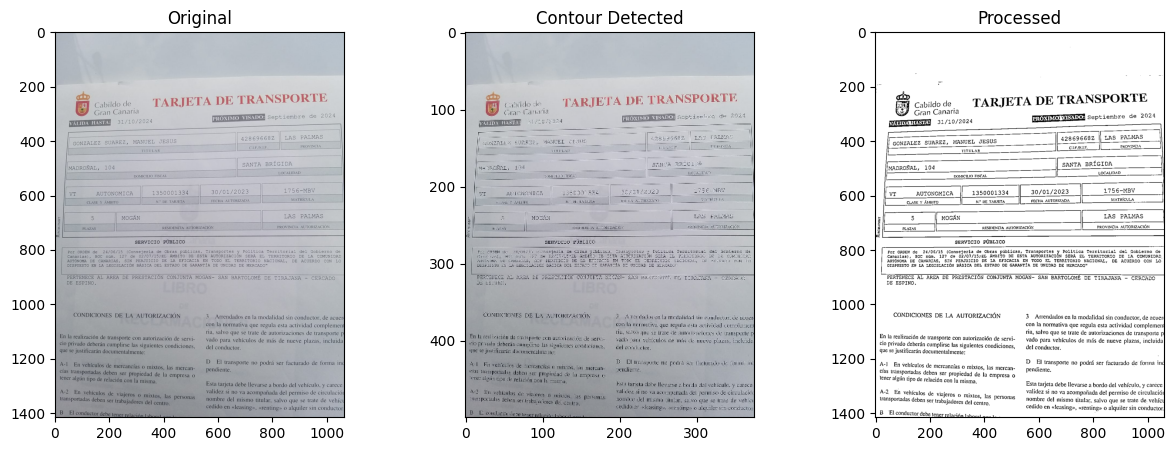

True

In [ ]:
test_image_path = "document.jpg"  # Cambia por la ruta a tu imagen
scanned = scan_document(test_image_path, debug=True)

cv2.imwrite("document_scanned.jpg", scanned)


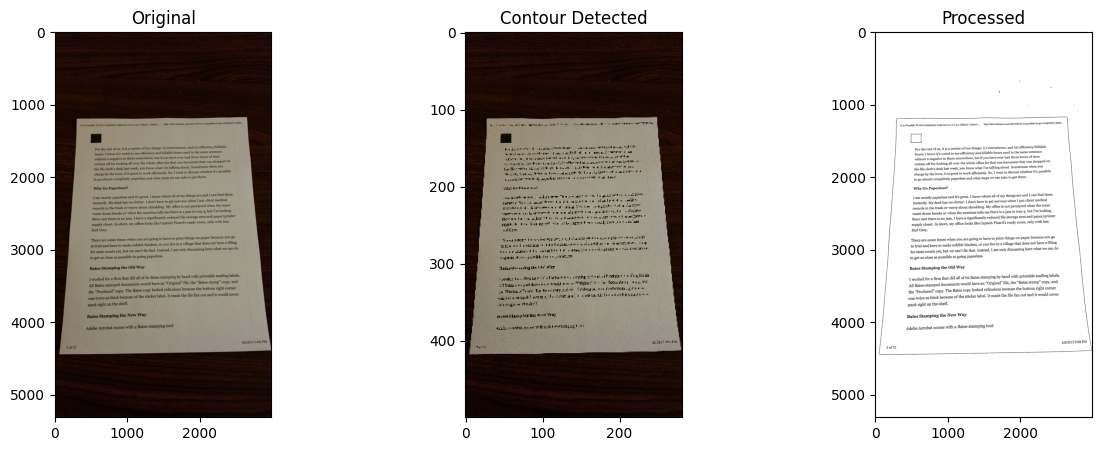

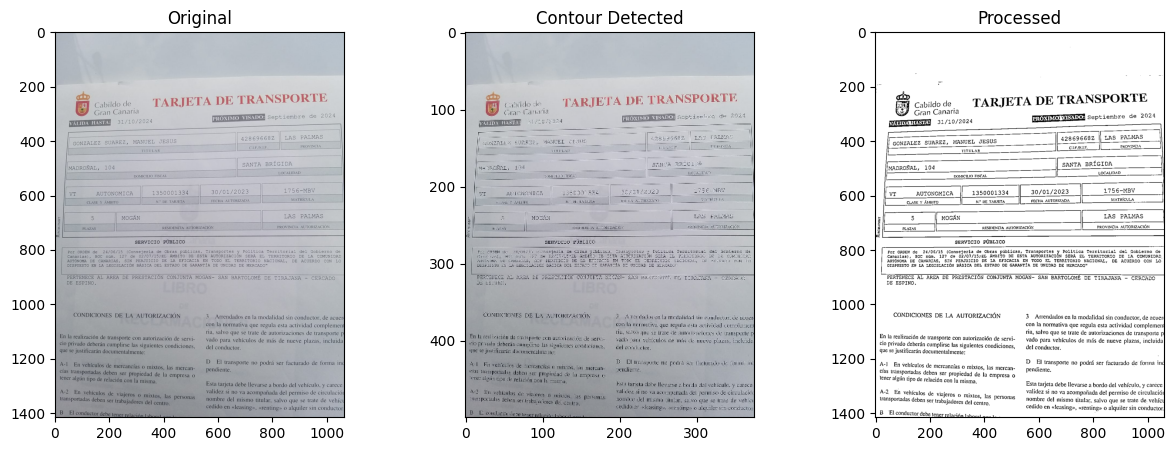

True

In [ ]:
# test_image_path = "desk.jpeg"  # Cambia por la ruta a tu imagen
# scanned = scan_document(test_image_path, debug=True)
# cv2.imwrite("desk_scanned.jpg", scanned)

test_image_path = "cell_pic.jpg"  # Cambia por la ruta a tu imagen
scanned = scan_document(test_image_path, debug=True)
cv2.imwrite("cell_pic_scanned.jpg", scanned)

test_image_path = "document.jpg"  # Cambia por la ruta a tu imagen
scanned = scan_document(test_image_path, debug=True)
cv2.imwrite("document_scanned.jpg", scanned)

Contour 1:
  - Area: 158.50
  - Perimeter: 49.07
  - Approximated Points: [[ 46 133]
 [ 46 143]
 [ 49 144]
 [ 59 143]
 [ 60 141]
 [ 59 132]]
Contour 2:
  - Area: 9.50
  - Perimeter: 2282.60
  - Approximated Points: [[247 110]
 [ 28 113]
 [  6 418]
 [280 413]
 [  5 415]
 [ 30 112]
 [248 112]
 [280 402]]


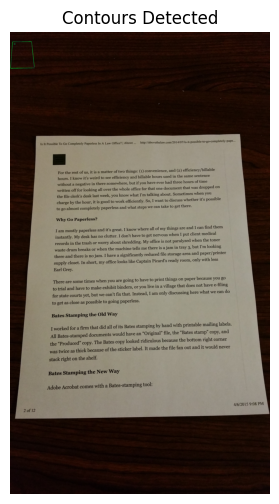

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_contours(image_path):
    # Load image
    image = cv2.imread(image_path)
    orig = image.copy()

    # Preprocess the image
    RESCALED_HEIGHT = 500.0
    ratio = image.shape[0] / RESCALED_HEIGHT
    image = cv2.resize(image, (int(image.shape[1] / ratio), int(RESCALED_HEIGHT)))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    edged = cv2.Canny(dilated, 0, 84)

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]  # Top 5 contours

    # Draw and print contour information
    for idx, c in enumerate(contours):
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        area = cv2.contourArea(c)

        print(f"Contour {idx + 1}:")
        print(f"  - Area: {area:.2f}")
        print(f"  - Perimeter: {peri:.2f}")
        print(f"  - Approximated Points: {approx.reshape(-1, 2)}")

        # Draw contour and approximated shape
        cv2.drawContours(orig, [approx], -1, (0, 255, 0), 2)  # Green for approximation
        cv2.drawContours(orig, [c], -1, (255, 0, 0), 1)       # Blue for original contour

    # Display result
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title("Contours Detected")
    plt.axis('off')
    plt.show()

# Example usage
display_contours("cell_pic.jpg")
